## Spark cluster intro Air quality examples

### Initialization
We use AWS Elastic Map Reduce (EMR) service to run a cluster and access data from S3.

#### Cluster Configuration
(EMR -> Create Cluster -> Go to advanced options)
 * Release label: emr-6.8.0
 * Hadoop distribution: Amazon 3.2.1
 * Applications: JupyterEnterpriseGateway 2.1.0, Spark 3.3.0

In [111]:
from pyspark.sql import SparkSession, SQLContext
from pyspark.conf import SparkConf
from pyspark.sql.functions import udf, to_timestamp, to_date
from pyspark.sql.types import TimestampType, DateType
from pyspark.sql.window import Window
spark = SparkSession.builder.getOrCreate()
sc = spark.sparkContext

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

On EMR we may need to install some required packages

In [2]:
sc.install_pypi_package("pandas==1.1.3") #Install pandas

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [3]:
sc.install_pypi_package("kiwisolver==1.2.0")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [4]:
sc.install_pypi_package("Pillow==8.0.1")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [5]:
sc.install_pypi_package("matplotlib==3.3.2")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [6]:
sc.list_packages()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Package                    Version  
-------------------------- ---------
beautifulsoup4             4.9.1    
boto                       2.49.0   
certifi                    2022.9.24
click                      7.1.2    
cycler                     0.11.0   
jmespath                   0.10.0   
joblib                     0.15.1   
kiwisolver                 1.2.0    
lxml                       4.5.1    
matplotlib                 3.3.2    
mysqlclient                1.4.2    
nltk                       3.5      
nose                       1.3.4    
numpy                      1.16.5   
pandas                     1.1.3    
Pillow                     8.0.1    
pip                        9.0.1    
py-dateutil                2.2      
pyparsing                  3.0.9    
python-dateutil            2.8.2    
python37-sagemaker-pyspark 1.3.0    
pytz                       2020.1   
PyYAML                     5.3.1    
regex                      2020.6.8 
setuptools                 28.8.0   
s

### Reading data from AWS S3

Now we can read a small sample of data:

In [7]:
smog_df = spark.read.json("s3a://openaq-fetches/realtime/2022-10-28/*")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [8]:
smog_df.printSchema()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- _corrupt_record: string (nullable = true)
 |-- attribution: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- name: string (nullable = true)
 |    |    |-- url: string (nullable = true)
 |-- averagingPeriod: struct (nullable = true)
 |    |-- unit: string (nullable = true)
 |    |-- value: double (nullable = true)
 |-- city: string (nullable = true)
 |-- coordinates: struct (nullable = true)
 |    |-- latitude: double (nullable = true)
 |    |-- longitude: double (nullable = true)
 |-- country: string (nullable = true)
 |-- date: struct (nullable = true)
 |    |-- local: string (nullable = true)
 |    |-- raw: string (nullable = true)
 |    |-- utc: string (nullable = true)
 |-- location: string (nullable = true)
 |-- mobile: boolean (nullable = true)
 |-- parameter: string (nullable = true)
 |-- sourceName: string (nullable = true)
 |-- sourceType: string (nullable = true)
 |-- unit: string (nullable = true)
 |-- value: double (nullable =

### Simple queries

In [9]:
smog_df.count()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

5326635

In [10]:
smog_df.select('parameter').distinct().toPandas()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

  parameter
0      None
1        co
2      pm10
3       so2
4       no2
5        bc
6      pm25
7        o3

In [11]:
smog_df.select('parameter').distinct().toPandas()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

  parameter
0      None
1        co
2      pm10
3       so2
4       no2
5        bc
6      pm25
7        o3

In [12]:
smog_df.select('country').distinct().toPandas()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

    country
0        DZ
1        FI
2        MN
3        MX
4        CZ
..      ...
101      TH
102      MA
103      NO
104      AF
105      CF

[106 rows x 1 columns]

In [13]:
from pyspark.sql.functions import col, asc, desc, max

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [14]:
smog_df.filter(col('country')=='PL').select('city').distinct().toPandas()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

            city
0       Jarosław
1         Rybnik
2      Widuchowa
3         Ustroń
4           Łódź
..           ...
166   Krapkowice
167        Tychy
168  Dzierżoniów
169        Opole
170     Zielonka

[171 rows x 1 columns]

### Some more interesting statistics

In [15]:
# Flatten the dataframe
smog_df=smog_df.select("location", "city", "country","parameter", "unit", "value",\
                col("date.local").alias("date_local"),\
                col("date.utc").alias("date_utc"),\
                "coordinates.*", "averagingPeriod", "sourceName", "sourceType", "mobile")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [16]:
smog_df.printSchema()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- location: string (nullable = true)
 |-- city: string (nullable = true)
 |-- country: string (nullable = true)
 |-- parameter: string (nullable = true)
 |-- unit: string (nullable = true)
 |-- value: double (nullable = true)
 |-- date_local: string (nullable = true)
 |-- date_utc: string (nullable = true)
 |-- latitude: double (nullable = true)
 |-- longitude: double (nullable = true)
 |-- averagingPeriod: struct (nullable = true)
 |    |-- unit: string (nullable = true)
 |    |-- value: double (nullable = true)
 |-- sourceName: string (nullable = true)
 |-- sourceType: string (nullable = true)
 |-- mobile: boolean (nullable = true)

In [17]:
max_pm10 = smog_df.filter(col('parameter')=='pm10')\
            .filter(col('value')>0.0)\
            .filter(col('country')=='PL')\
            .groupBy('city').agg(max('value').alias('maxpm10'))\
            .sort(col('maxpm10').desc())

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [18]:
pd_pm10 = max_pm10.limit(10).toPandas()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [19]:
pd_pm10

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

              city  maxpm10
0           Krosno  187.909
1        Nowa Ruda  183.232
2   Janów Lubelski  144.300
3           Mosina  138.742
4          Pińczów  128.010
5        Bydgoszcz  110.400
6        Nowy Targ  107.744
7            Biała  107.000
8            Łomża  106.400
9  Sucha Beskidzka  104.062

In [20]:
import matplotlib.pyplot as plt

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [21]:
pd_pm10.plot.barh(x = 'city')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

<AxesSubplot:ylabel='city'>

To show the plot we need this magic:

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

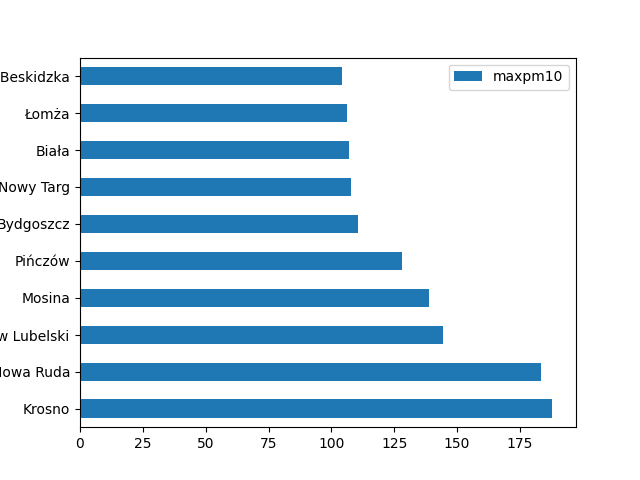

In [22]:
%matplot plt

# Homework

In [23]:
from pyspark.sql import functions as F

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [24]:
from datetime import datetime

from dateutil import parser
import matplotlib.pyplot as plt
import numpy as np
from time import time
from datetime import datetime



VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [118]:
smog_df = spark.read.json("s3a://openaq-fetches/realtime/2022-10-*/*")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [124]:
smog_df=smog_df.select("location", "city", "country","parameter", "unit", "value",\
                col("date.local").alias("date_local"),\
                col("date.utc").alias("date_utc"),\
                col("coordinates.latitude").alias("latitude"), col("coordinates.longitude").alias("longitude"),\
                "averagingPeriod", "sourceName", "sourceType", "mobile")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

cannot resolve '`date.utc`' given input columns: [averagingPeriod, city, country, date_local, date_utc, latitude, location, longitude, mobile, parameter, sourceName, sourceType, unit, value];;
'Project [location#1703, city#1699, country#1701, parameter#1705, unit#1708, value#1709, 'date.utc AS date_utc#1755, 'coordinates.latitude AS latitude#1756, 'coordinates.longitude AS longitude#1757, averagingPeriod#1698, sourceName#1706, sourceType#1707, mobile#1704]
+- Project [location#1703, city#1699, country#1701, parameter#1705, unit#1708, value#1709, date#1702.local AS date_local#1724, date#1702.utc AS date_utc#1725, coordinates#1700.latitude AS latitude#1726, coordinates#1700.longitude AS longitude#1727, averagingPeriod#1698, sourceName#1706, sourceType#1707, mobile#1704]
   +- Relation[_corrupt_record#1696,attribution#1697,averagingPeriod#1698,city#1699,coordinates#1700,country#1701,date#1702,location#1703,mobile#1704,parameter#1705,sourceName#1706,sourceType#1707,unit#1708,value#1709] js

Znajdź miasta w Polsce, w których średnie stężenie pyłu “pm25” było niższe niż maksymalne stężenie w Paryżu (w całym badanym okresie). Obliczenia wykonaj dla danych z kilku dni. Wyniki posortuj malejąco po stężeniu pm25.

In [125]:
smog_5_days_df = smog_df.where(
    (F.col("date_utc") >= F.lit("2022-10-20T00:00:000Z")) &
    (F.col("date_utc") <  F.lit("2022-10-25T00:00:000Z"))
)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [126]:
smog_5_days_df.show(10)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+-----+-------+---------+----+-----+--------------------+--------------------+--------+---------+---------------+--------------+----------+------+
|            location| city|country|parameter|unit|value|          date_local|            date_utc|latitude|longitude|averagingPeriod|    sourceName|sourceType|mobile|
+--------------------+-----+-------+---------+----+-----+--------------------+--------------------+--------+---------+---------------+--------------+----------+------+
|US Diplomatic Pos...|Dubai|     AE|       o3| ppm|0.047|2022-10-21T13:00:...|2022-10-21T09:00:...|25.25848|55.309166|   [hours, 1.0]|StateAir_Dubai|government| false|
|US Diplomatic Pos...|Dubai|     AE|       o3| ppm|0.077|2022-10-21T14:00:...|2022-10-21T10:00:...|25.25848|55.309166|   [hours, 1.0]|StateAir_Dubai|government| false|
|US Diplomatic Pos...|Dubai|     AE|       o3| ppm|0.088|2022-10-21T15:00:...|2022-10-21T11:00:...|25.25848|55.309166|   [hours, 1.0]|StateAir_Dubai|government|

In [127]:
smog_5_days_df.where((F.col("country") == "FR")).show(20)


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------+--------------+-------+---------+-----+------+--------------------+--------------------+----------------+-----------------+---------------+----------+----------+------+
|location|          city|country|parameter| unit| value|          date_local|            date_utc|        latitude|        longitude|averagingPeriod|sourceName|sourceType|mobile|
+--------+--------------+-------+---------+-----+------+--------------------+--------------------+----------------+-----------------+---------------+----------+----------+------+
| FR34047|  Eure-et-Loir|     FR|       co|µg/m³| 341.0|2022-10-22T03:00:...|2022-10-22T01:00:...| 48.760911372973|  1.2336473965285|   [hours, 1.0]|EEA France|government| false|
| FR34047|  Eure-et-Loir|     FR|       co|µg/m³| 256.0|2022-10-22T04:00:...|2022-10-22T02:00:...| 48.760911372973|  1.2336473965285|   [hours, 1.0]|EEA France|government| false|
| FR34047|  Eure-et-Loir|     FR|       co|µg/m³| 320.0|2022-10-22T05:00:...|2022-10-22T03:00:...| 48.760

In [128]:
paris_max = (
    smog_5_days_df
    .where((F.col("city") == "Paris") &
           (F.col("parameter") == "pm25"))
    .select(F.max(F.col("value")))
    .first()
)[0]

print(paris_max)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

24.0

In [129]:
cities = (
    smog_5_days_df
    .select("city", "value")
    .where(
        (F.col("country") == "PL") &
        (F.col("parameter") == "pm25")
    )
    .groupBy("city")
    .agg(F.avg("value").alias("avg_value"))
    .where(F.col("avg_value") < paris_max)
    .orderBy(F.desc("avg_value"))
)

cities.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+------------------+------------------+
|              city|         avg_value|
+------------------+------------------+
|  Jastrzębie-Zdrój|23.743799010791367|
|          Racibórz|23.687600992779824|
|         Legionowo|23.295029821073577|
|            Lębork| 23.28327351782364|
|            Kraków| 22.86474701811425|
|          Żyrardów| 22.83389662027832|
|            Sierpc| 21.18706467661692|
|            Kielce| 21.04203420342036|
|            Kalisz|21.026154758064514|
|Goczałkowice-Zdrój|20.756008388838882|
|           Siedlce| 20.70536779324056|
|             Toruń|20.375796178343933|
|            Gdańsk| 20.23714388471178|
|         Szamotuły|20.225976586345368|
|          Szczytno| 19.91188575984992|
|             Nisko| 19.84803440000001|
|           Piastów| 19.83220675944334|
|              Nysa|19.767521621093756|
|          Jarosław|19.498106679069743|
|          Augustów|19.436093609360952|
+------------------+------------------+
only showing top 20 rows

Dla danych z wybranych kilku dni przedstaw w ujęciu godzinowym (wybierz czas UTC) najwyższe zanotowane stężenie pm10 w poszczególnych miastach z całego zbioru danych. Wyniki posortuj po rosnąco datach.

In [130]:
def print_n_records_for_city(city: str, n: int) -> None:
    results = (
        smog_5_days_df
        .select("city", "date_utc", "parameter", "value")
        .na.drop()
        .withColumn("datetime", to_timestamp(F.col("date_utc")))
        .where(
            (F.col("city") == city) &
            (F.col("parameter") == "pm25")
        )
        .groupBy("datetime")
        .agg(F.max("value").alias("max_pm25_value"))
        .orderBy("datetime")
    )
    results.show(n)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [131]:
print_n_records_for_city("Paris", 20)


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------------------+--------------+
|           datetime|max_pm25_value|
+-------------------+--------------+
|2022-10-20 01:00:00|          15.1|
|2022-10-20 02:00:00|          17.3|
|2022-10-20 03:00:00|          13.3|
|2022-10-20 04:00:00|          16.6|
|2022-10-20 05:00:00|           8.8|
|2022-10-20 06:00:00|          19.8|
|2022-10-20 07:00:00|          11.8|
|2022-10-20 08:00:00|          16.1|
|2022-10-20 09:00:00|           8.8|
|2022-10-20 10:00:00|          15.0|
|2022-10-20 11:00:00|           8.9|
|2022-10-20 12:00:00|          15.0|
|2022-10-20 13:00:00|           5.4|
|2022-10-20 14:00:00|          14.3|
|2022-10-20 15:00:00|           7.0|
|2022-10-20 16:00:00|          17.0|
|2022-10-20 17:00:00|           7.9|
|2022-10-20 18:00:00|          16.4|
|2022-10-20 19:00:00|          14.3|
|2022-10-20 20:00:00|          14.7|
+-------------------+--------------+
only showing top 20 rows

Znajdź ranking miast w Europie pod względem średniego zanieczyszczenia liczonego dla N najwyższych pomiarów pod względem “pm25” dla danych z kilku dni. 

In [132]:
def get_most_polluted_cities(n: int):
    window = Window.partitionBy("city").orderBy("value")

    df = (
        smog_5_days_df
        .select("city", "parameter", "value")
        .na.drop()
        .where(
            (F.col("parameter") == "pm25"))
        .withColumn("rank", F.rank().over(window))
    )

    df = (
        df
        .select("city", "value")
        .where(F.col("rank") <= n)
        .groupBy("city")
        .agg(F.avg("value").alias(f"avg_pm25_top_{n}_measurements"))
        .orderBy(F.desc(f"avg_pm25_top_{n}_measurements"))
    )
    return df

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [133]:
get_most_polluted_cities(15).show(15)


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-----------------+----------------------------+
|             city|avg_pm25_top_15_measurements|
+-----------------+----------------------------+
| Ho Chi Minh City|           983.7987891019172|
|            Dubai|                        43.0|
|            Delhi|                        42.0|
|            BURKE|                        27.5|
|         Peshawar|                        26.0|
|       Ratchaburi|                        26.0|
|        Abu Dhabi|                        25.0|
|            Phrae|           24.90740740740741|
|     Samut Sakhon|          24.764705882352942|
|  Padre las Casas|                        23.0|
|        Chon buri|                        21.0|
|       La Florida|                        20.0|
|Nakhon Ratchasima|                        20.0|
|     Puerto Varas|                        20.0|
|           Murcia|          19.605882352941173|
+-----------------+----------------------------+
only showing top 15 rows

Zwizualizuj na mapie średnie zanieczyszczenie w danym kraju dla wybranych kilku dni względem czasu (mapa + slider czasu albo zbiór klatek i animacja) dla wybranych państw.

In [141]:
def get_country_heatmap(country: str):
    df = (
        smog_5_days_df
        .select("latitude", "longitude", "value", "date_utc")
        .na.drop()
        .where(
            (F.col("parameter") == "pm25") &
            (F.col("country") == country)
        )
        .withColumn("datetime", to_timestamp(F.col("date_utc")))
        .withColumn("date", to_date("datetime"))
    )
    df = (
        df
        .groupBy("latitude", "longitude", "date")
        .agg(F.avg("value").alias("avg_value"))
        .orderBy("date", "latitude", "longitude")
        .select("date", "latitude", "longitude", "avg_value")
    )
    return df

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [142]:
%%spark -o pdf

pdf = get_country_heatmap("PL")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

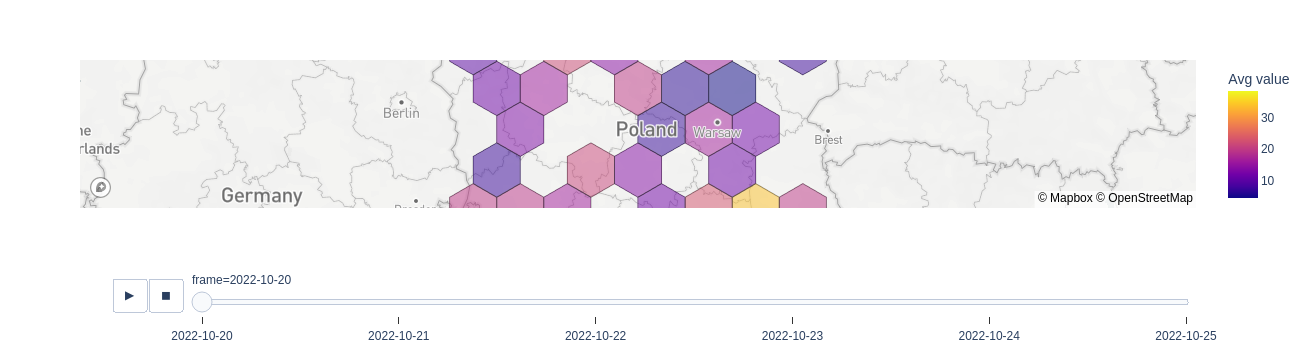

In [144]:
%%local

import numpy as np
import pandas as pd
import plotly.express as px
import plotly.figure_factory as ff

px.set_mapbox_access_token("pk.eyJ1IjoiamdhcmdhcyIsImEiOiJjbGFoN3Fna2owcmZnM3ZtcHhuMDBzMjM3In0.cdIiJLgqb72oJ9P2RcvGoQ")
pdf = pdf.astype({"date": str})

fig = ff.create_hexbin_mapbox(
    data_frame=pdf,
    lat="latitude",
    lon="longitude",
    nx_hexagon=8,
    opacity=0.5,
    color="avg_value",
    labels={"color": "Avg value"},
    min_count=1,
    animation_frame="date",
    agg_func=np.mean
)

fig.show()

## Korzystanie z klastra dla dużych danych
1. Proszę wykonać zadanie 1 dla danych z całego miesiąca. Zmierzyć czas wykonania
2. Zwiększyć klaster do 2, 3, 4, 5, 6, 7 instancji workerów i zmierzyć czasy wykonania
3. Narysować wykresy czasu, przyspieszenia, efektywności oraz miarę Karpa-Flatta (time, speedup, efficiency)

In [145]:
# smog_df = spark.read.json("s3a://openaq-fetches/realtime/2022-10-*/*")
smog_month_df = smog_df.where(
    (F.col("date_utc") >= F.lit("2022-10-01T00:00:000Z")) &
    (F.col("date_utc") <  F.lit("2022-11-01T00:00:000Z"))
)

start = time()

paris_max = (
    smog_month_df
    .where((F.col("city") == "Paris") &
           (F.col("parameter") == "pm25"))
    .select(F.max(F.col("value")))
    .first()
)[0]

cities = (
    smog_month_df
    .select("city", "value")
    .where(
        (F.col("country") == "PL") &
        (F.col("parameter") == "pm25")
    )
    .groupBy("city")
    .agg(F.avg("value").alias("avg_value"))
    .where(F.col("avg_value") < paris_max)
    .orderBy(F.desc("avg_value"))
)

end = time()
print(end - start)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

78.41200470924377

In [146]:
workers = np.arange(1, 8)
times = np.array([570, 294, 191, 135, 113, 107, 80])
speedups = times[0] / times
efficiencies = speedups / workers

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

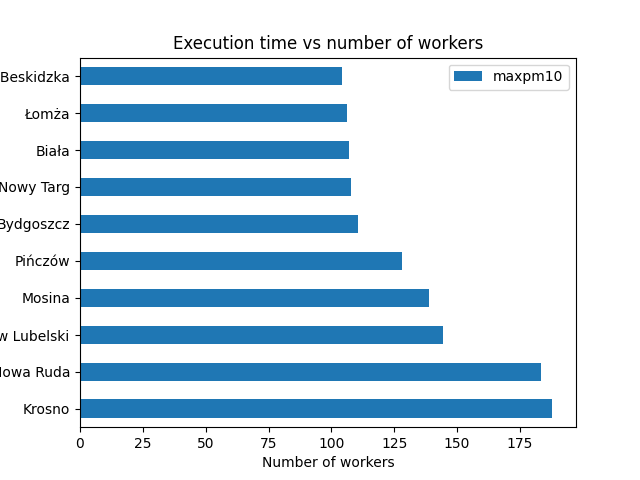

In [147]:
plt.scatter(workers, times)
plt.xlabel("Number of workers")
plt.ylabel("Execution time")
plt.title("Execution time vs number of workers")
plt.show()
%matplot plt

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

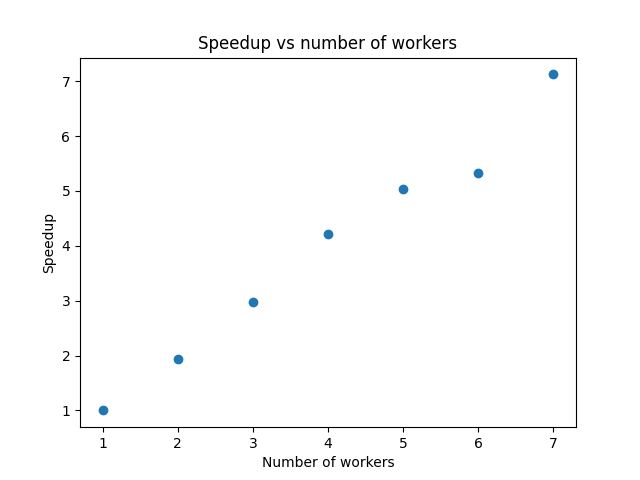

In [148]:
plt.clf()
plt.scatter(workers, speedups)
plt.xlabel("Number of workers")
plt.ylabel("Speedup")
plt.title("Speedup vs number of workers")
plt.show()
%matplot plt

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

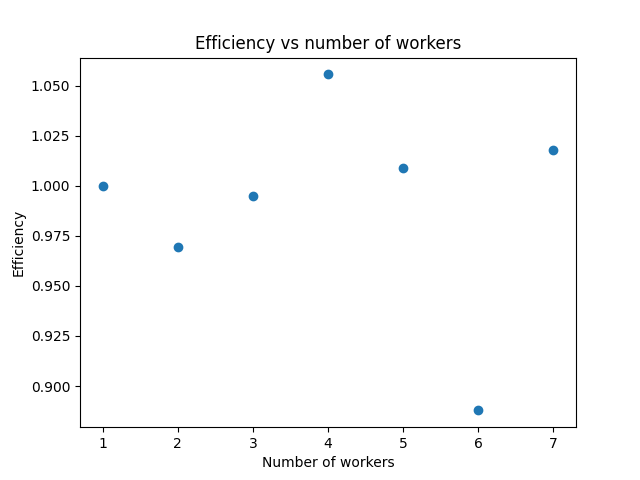

In [149]:
plt.clf()
plt.scatter(workers, efficiencies)
plt.xlabel("Number of workers")
plt.ylabel("Efficiency")
plt.title("Efficiency vs number of workers")
plt.show()
%matplot plt

Wykonaj przykładowe zapytanie dla danych z całego roku 2021

In [ ]:
smog_2021_df = spark.read.json("s3a://openaq-fetches/realtime/2021-*-*/*")
smog_2021_df = smog_2020_df.where(
    (F.col("date.utc") >= F.lit("2021-01-01T00:00:000Z")) &
    (F.col("date.utc") <  F.lit("2022-01-01T00:00:000Z"))
)

poland_pm10_max = (
    smog_2020_df
    .where((F.col("country") == "PL") &
           (F.col("parameter") == "pm10"))
    .select(F.max(F.col("value")))
    .first()
)

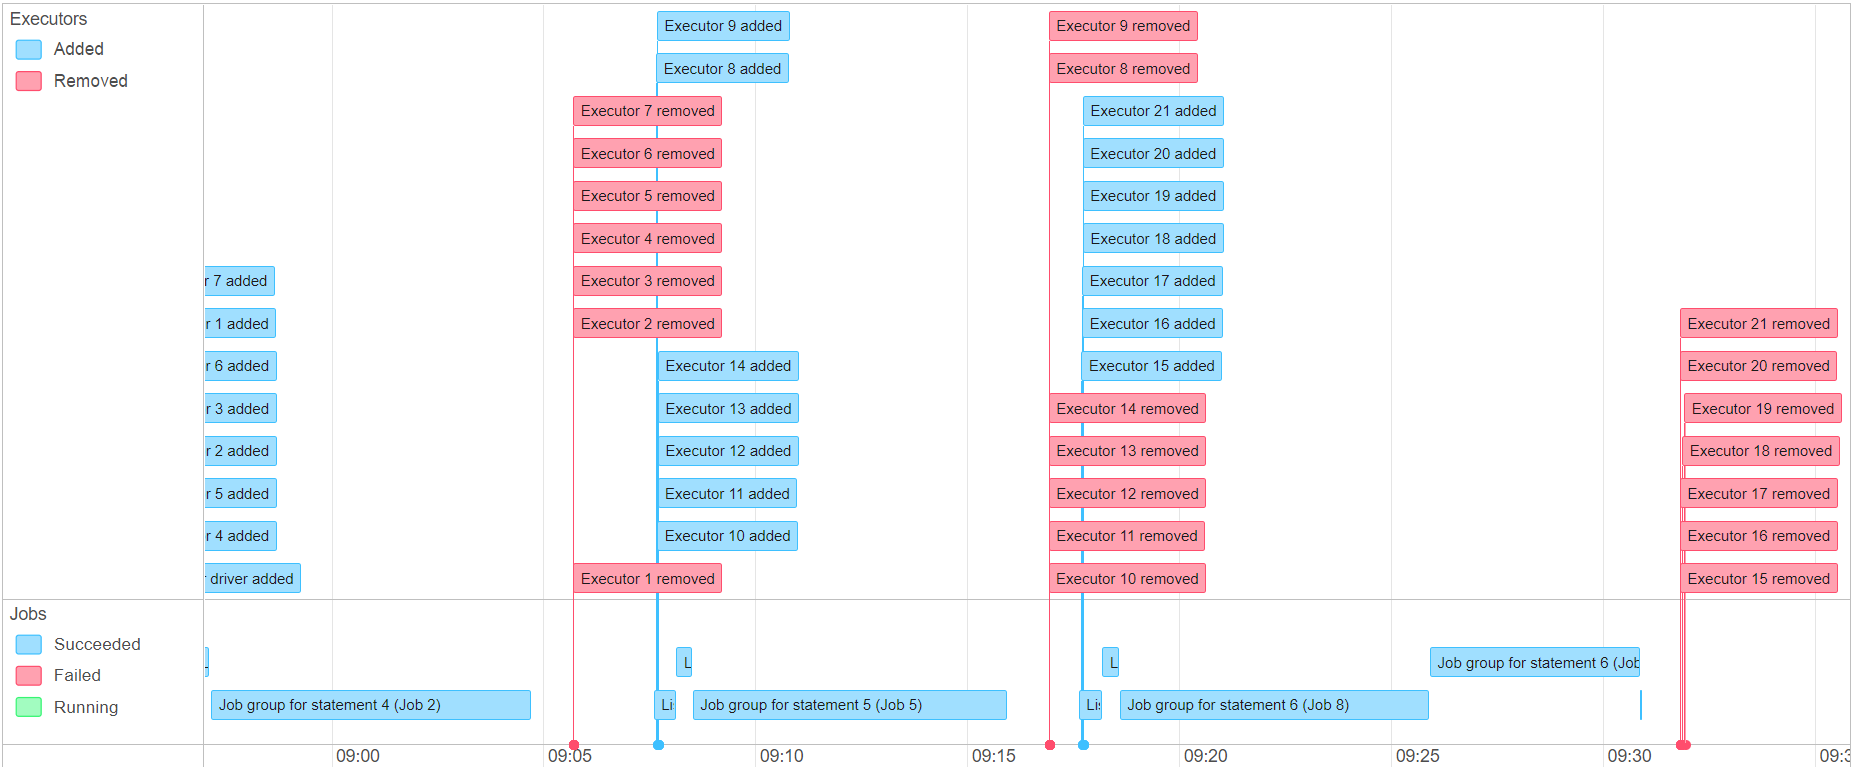

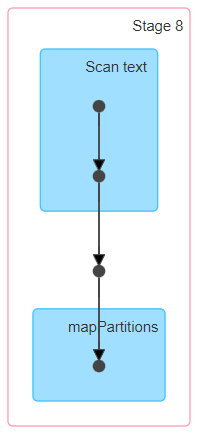

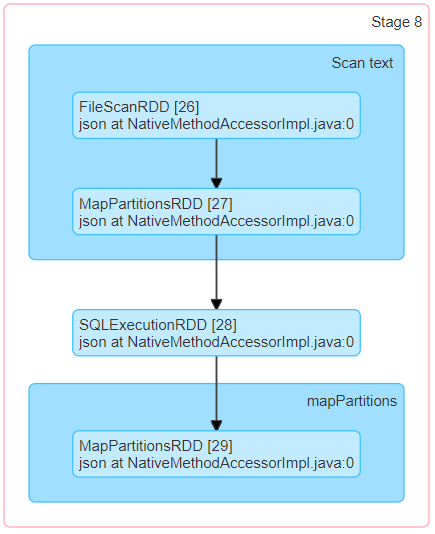